# Image Recognition Project

Authors:

> - André Oliveira
> - Diogo Ribeiro Santos
> - Gonçalo Eloy
> - Gonçalo Matos
> - Rafael Chamusca

**Data Set**:

Diabetic Retinopathy Data Set. The data set is available [here](https://www.kaggle.com/c/diabetic-retinopathy-detection/data).

In [ ]:
import os
import warnings
import zipfile
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from sklearn.metrics import roc_auc_score
from tensorflow.keras import datasets
import numpy as np

In [ ]:
tf.keras.backend.clear_session()

#**Diabetic Retinopathy Data Set - Diagnosis with Convolutional Neural Networks (CNNs)**



**Using Kaggle API to download the data**

In [ ]:
# Uncomment the following line if need to

#!pip install kaggle

# **Data Set Upload**

In [ ]:
from google.colab import files

#Uploading through API
uploaded = files.upload()

#Moving the file to directory
!mkdir -p /root/.kaggle
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


# **Data Set download with kaggle API**

In [ ]:
import kaggle
import zipfile

#Geting the dataset
dataset_name = 'pkdarabi/diagnosis-of-diabetic-retinopathy'

#Defining directory
destination_dir = '/content/dataset'

# Using the API to download the files
kaggle.api.dataset_download_files(dataset_name, path=destination_dir, unzip=True)

#Listing the content
dataset_contents = os.listdir(destination_dir)
print("Dataset contents:", dataset_contents)

Dataset contents: ['test', 'valid', 'train']


#**Aternative to the Above if not working**

In [ ]:
import os

#Defining credentials
os.environ['KAGGLE_USERNAME'] = 'gonaloeloy'
os.environ['KAGGLE_KEY'] = 'c991651d0d91b8202bff8ff3f8cc4531'

# Defining directory and dataset
dataset_name = 'pkdarabi/diagnosis-of-diabetic-retinopathy'
destination_dir = '/content/dataset'

#Using Kaggle CLI to download
!kaggle datasets download -d {dataset_name} -p {destination_dir}

#Unzip the files
with zipfile.ZipFile(os.path.join(destination_dir, f"{dataset_name.split('/')[1]}.zip"), 'r') as zip_ref:
    zip_ref.extractall(destination_dir)

#Listing the content
dataset_contents = os.listdir(destination_dir)
print("Dataset contents:", dataset_contents)

 54% 8.00M/14.9M [00:00<00:00, 83.2MB/s]
100% 14.9M/14.9M [00:00<00:00, 99.5MB/s]
Dataset contents: ['test', 'valid', 'train', 'diagnosis-of-diabetic-retinopathy.zip']


# **Train, Test and Validation folders**

In [ ]:
directory_to_explore = '/content/dataset'

target_subfolders = ['train', 'test', 'valid']

# List the subfolders within the specified directory
subfolders = [f.name for f in os.scandir(directory_to_explore) if f.is_dir() and f.name in target_subfolders]

# Print the subfolders
print("Subfolders in", directory_to_explore, ":", subfolders)

Subfolders in /content/dataset : ['test', 'valid', 'train']


# **Images**

Subfolder: No_DR


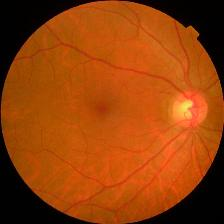

Image resolution: (224, 224)

Subfolder: DR


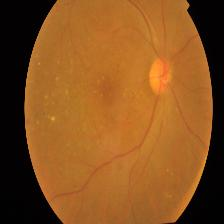

Image resolution: (224, 224)



In [ ]:
from IPython.display import Image, display, HTML
from PIL import Image as PILImage

# ESpecify directory
parent_directory = '/content/dataset/train'

# Listing subfolders in specified directory - DR (Diabetic Retinopathy), No_DR ( No Diabetic Retinopathy)
subfolders = [f.name for f in os.scandir(parent_directory) if f.is_dir()]

# Showing one image from each subfolder with subfolder's name
for subfolder in subfolders:
    #Print subfolder's name
    print(f"Subfolder: {subfolder}")

    # Geting the path for the first image in the subfolder
    first_image_path = os.path.join(parent_directory, subfolder, os.listdir(os.path.join(parent_directory, subfolder))[0])

    # Displaying the image using Image class
    display(Image(filename=first_image_path, width=200))

    with PILImage.open(first_image_path) as img:
      resolution = img.size
      print(f"Image resolution: {resolution}\n")


One can see the differences in the retina (back of the eye), between Diabetic Retinopathy and No Diabetic Retinopathy.

Also, the images have a height of 224 and width of 224. The shape of the images is (224, 224, 3).

# **Samples**

In [ ]:
# Root dir
parent_directory = '/content/dataset'

# Listing subfolders in training, validation and test directories
train_directory = os.path.join(parent_directory, 'train')
test_directory = os.path.join(parent_directory, 'test')
validation_directory = os.path.join(parent_directory, 'valid')

# Function for counting the number of files in each directory
def count_images(directory):
    return sum([len(files) for _, _, files in os.walk(directory)])

# Listing subfolders in training, validation and test directories
train_subfolders = [f.name for f in os.scandir(train_directory) if f.is_dir()]
test_subfolders = [f.name for f in os.scandir(test_directory) if f.is_dir()]
validation_subfolders = [f.name for f in os.scandir(validation_directory) if f.is_dir()]

# Counting the number of images in each class in training directories
for subfolder in train_subfolders:
    class_directory = os.path.join(train_directory, subfolder)
    num_images = count_images(class_directory)
    print(f"Train - Classe: {subfolder}, Número de imagens: {num_images}")

# Counting the number of images in each class in validation directories
for subfolder in validation_subfolders:
    class_directory = os.path.join(validation_directory, subfolder)
    num_images = count_images(class_directory)
    print(f"Validation - Classe: {subfolder}, Número de imagens: {num_images}")

# Counting the number of images in each class in test directories
for subfolder in test_subfolders:
    class_directory = os.path.join(test_directory, subfolder)
    num_images = count_images(class_directory)
    print(f"Test - Classe: {subfolder}, Número de imagens: {num_images}")



Train - Classe: No_DR, Número de imagens: 1026
Train - Classe: DR, Número de imagens: 1050
Validation - Classe: No_DR, Número de imagens: 286
Validation - Classe: DR, Número de imagens: 245
Test - Classe: No_DR, Número de imagens: 118
Test - Classe: DR, Número de imagens: 113


DR is more represented on the training set, while No_DR is more represented on both validation and test sets.

The test set will be used for predictions.

# **Preprocessing**

In [ ]:
# The preprocessing will be done along with the model creation to ensure that each model is autonomous.

# **Modeling**

## **Base Model v1**

**Model Architecture**

Convolutional Neural Network with 2 convolutional layers. Each followed by max-pooling layers. Then, flatten before two fully connected (dense) layers.

ReLU activation function for the convolutional and dense layers. The output layer has a sigmoid activation function.

In [ ]:
import numpy as np
from numpy.random import seed
import pandas as pd
import random as rn
import os

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.compat.v1.keras import backend as K

tf.keras.backend.clear_session()

seed_num = 18
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(seed_num)
rn.seed(seed_num)
tf.random.set_seed(seed_num)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

In [ ]:
#To ensure reproductibility
seed = 19 #Aplied to the generators

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Model
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

# Compiling the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Criating data generators for training, validation and testing
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Target_size will equal image resolution, to ensure minimal information loss
training_set = train_datagen.flow_from_directory('/content/dataset/train',
                                                 target_size=(224, 224),
                                                 batch_size=32,
                                                 seed = seed,
                                                 class_mode='binary')

val_set = val_datagen.flow_from_directory('/content/dataset/valid',
                                          target_size=(224, 224),
                                          batch_size=32,
                                          seed = seed,
                                          class_mode='binary')

test_set = test_datagen.flow_from_directory('/content/dataset/test',
                                            target_size=(224, 224),
                                            batch_size=32,
                                            class_mode='binary',
                                            seed = seed,
                                            shuffle=False)  # Ensure order is maintained for later analysis

model.summary()

# Training the model
history = model.fit(training_set, steps_per_epoch=len(training_set), epochs=5, validation_data=val_set, validation_steps=len(val_set))

# Evaluating the model on validation set
eval_result_val = model.evaluate(val_set, steps=len(val_set))
print(f"\nValidation Loss: {eval_result_val[0]}, Validation Accuracy: {eval_result_val[1]}")

# Evaluating the model on test set
eval_result_test = model.evaluate(test_set, steps=len(test_set))
print(f"\nTest Loss: {eval_result_test[0]}, Test Accuracy: {eval_result_test[1]}")

# Predicting on test set
predictions = model.predict(test_set, steps=len(test_set))

# Evaluating predictions
threshold = 0.5
binary_predictions = (predictions > threshold).astype(int)
test_labels = test_set.classes

Found 2076 images belonging to 2 classes.
Found 531 images belonging to 2 classes.
Found 231 images belonging to 2 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 186624)            0        

Confusion Matrix
[[103  10]
 [  7 111]]

Classification Report
              precision    recall  f1-score   support

       No_DR       0.94      0.91      0.92       113
          DR       0.92      0.94      0.93       118

    accuracy                           0.93       231
   macro avg       0.93      0.93      0.93       231
weighted avg       0.93      0.93      0.93       231

ROC AUC: 0.9260911954402281


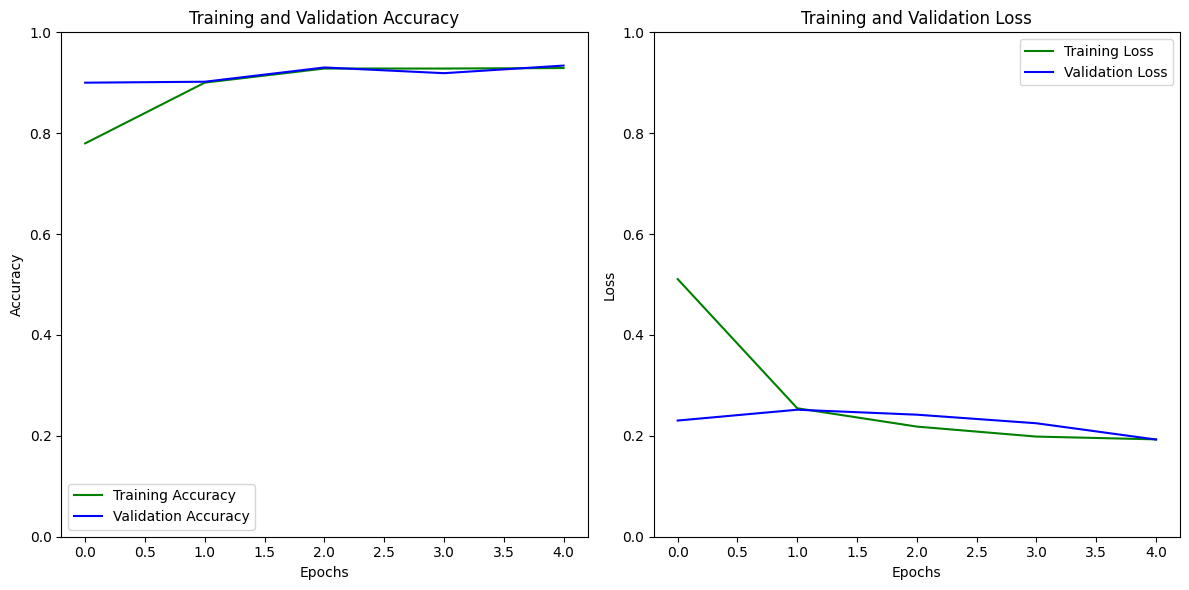

In [ ]:
# Print confusion matrix and classification report
print('Confusion Matrix')
print(confusion_matrix(test_labels, binary_predictions))
print('\nClassification Report')
target_names = ['No_DR', 'DR']
print(classification_report(test_labels, binary_predictions, target_names=target_names))

# Print ROC AUC Score
auc_v1 = roc_auc_score(test_labels, binary_predictions)
print(f'ROC AUC: {auc_v1}')

# Plot training and validation accuracy and loss side by side
plt.figure(figsize=(12, 6))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], 'g', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim(0, 1)  # Set y-axis limits to [0, 1]

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], 'g', label='Training Loss')
plt.plot(history.history['val_loss'], 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.ylim(0, 1)  # Set y-axis limits to [0, 1]

plt.tight_layout()
plt.show()

In [ ]:
# Create an ImageDataGenerator with specified augmentation parameters
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Create a flow_from_directory generator for training data
training_set = train_datagen.flow_from_directory(
    '/content/dataset/train',
    target_size=(224, 224),
    batch_size=32,
    seed = seed,
    class_mode='binary'
)


Found 2076 images belonging to 2 classes.


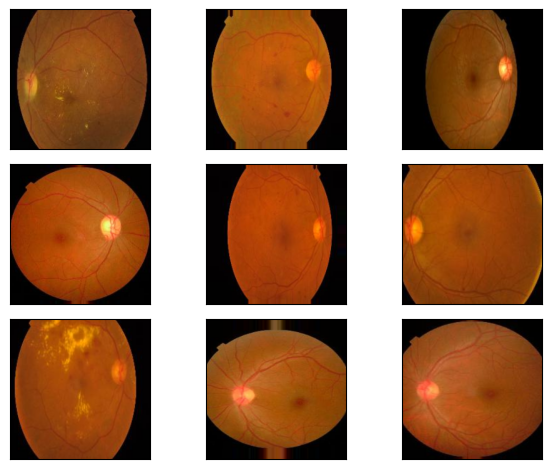

In [ ]:
# Grab a random batch of images from the training set
batch_images, batch_labels = training_set.next()

# Plot a few of the images
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    plt.imshow(batch_images[i], cmap='gray')  # Use batch_images directly without calling numpy
    plt.xticks([])
    plt.yticks([])

# Show the plot
plt.tight_layout()
plt.show()

Found 2076 images belonging to 2 classes.


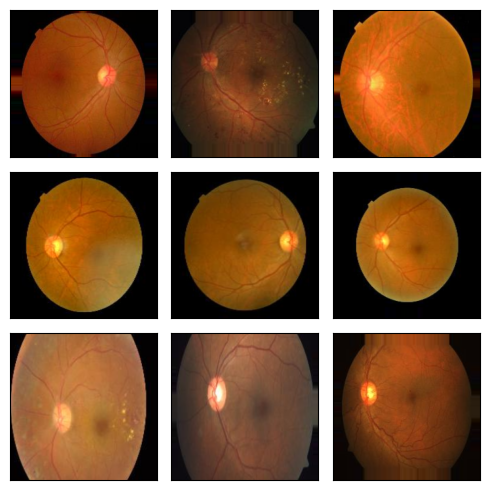

In [ ]:
# Criating data generators for training, validation and testing
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

# Target_size will equal image resolution, to ensure minimal information loss
training_set = train_datagen.flow_from_directory('/content/dataset/train',
                                                 target_size=(224, 224),
                                                 batch_size=32,

                                                 class_mode='binary')

# Grab a random batch of images from the training set
batch_images, _ = training_set.next()

# Plot a few of the images
plt.figure(figsize=(5, 5))
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    plt.imshow(batch_images[i], cmap='gray', vmin=0, vmax=1)
    plt.xticks([])
    plt.yticks([])

# Show the plot
plt.tight_layout()
plt.show()

## **Base model v2**

> - Changes in the compilation and data augmentation

Data Augmentation ("If you train a new network using this data-augmentation configuration, the network will never see the same input twice" Prof. Mauro Castelli)

v2_datagen = ImageDataGenerator(
  rotation_range = 40,
  width_shift_range = 0.2,
  height_shift_range = 0.2,
  shear_range = 0.2,
  zoom_range = 0.2,
  horizontal_flip = True,
  fill_mode = 'nearest'
)

Optimizer in compilation: RMSprop(lr=1e-4)



In [ ]:
import numpy as np
from numpy.random import seed
import pandas as pd
import random as rn
import os

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.compat.v1.keras import backend as K

tf.keras.backend.clear_session()

seed_num = 18
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(seed_num)
rn.seed(seed_num)
tf.random.set_seed(seed_num)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

In [ ]:
# Model
model2 = Sequential()
model2.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Flatten())
model2.add(Dense(units=128, activation='relu'))
model2.add(Dense(units=1, activation='sigmoid'))

# Compiling the model
from tensorflow.keras import optimizers
model2.compile(optimizer=optimizers.legacy.RMSprop(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Criating data generators for training, validation and testing
train_datagen2 = ImageDataGenerator(rescale=1./255,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode = 'nearest')
val_datagen2 = ImageDataGenerator(rescale=1./255)
test_datagen2 = ImageDataGenerator(rescale=1./255)

training_set2 = train_datagen2.flow_from_directory('/content/dataset/train',
                                                 target_size=(224, 224),
                                                 batch_size=32,
                                                 seed = seed,
                                                 class_mode='binary')

val_set2 = val_datagen2.flow_from_directory('/content/dataset/valid',
                                          target_size=(224, 224),
                                          batch_size=32,
                                          seed = seed,
                                          class_mode='binary')

test_set2 = test_datagen2.flow_from_directory('/content/dataset/test',
                                            target_size=(224, 224),
                                            batch_size=32,
                                            seed = seed,
                                            class_mode='binary',
                                            shuffle=False)  # Ensure order is maintained for later analysis

Found 2076 images belonging to 2 classes.
Found 531 images belonging to 2 classes.
Found 231 images belonging to 2 classes.


In [ ]:
model2.summary()

# Training the model
history2 = model2.fit(training_set2, steps_per_epoch=len(training_set2), epochs=10, validation_data=val_set2, validation_steps=len(val_set2))

# Evaluating the model on validation set
eval_result_val2 = model2.evaluate(val_set2, steps=len(val_set2))
print(f"\nValidation Loss: {eval_result_val2[0]}, Validation Accuracy: {eval_result_val2[1]}")

# Evaluating the model on test set
eval_result_test2 = model2.evaluate(test_set2, steps=len(test_set2))
print(f"\nTest Loss: {eval_result_test2[0]}, Test Accuracy: {eval_result_test2[1]}")

# Predicting on test set
predictions2 = model2.predict(test_set2, steps=len(test_set2))

# Evaluating predictions
threshold = 0.5
binary_predictions2 = (predictions2 > threshold).astype(int)
test_labels2 = test_set2.classes

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 186624)            0         
                                                                 
 dense (Dense)               (None, 128)               2

Confusion Matrix
[[ 95  18]
 [  2 116]]

Classification Report
              precision    recall  f1-score   support

       No_DR       0.98      0.84      0.90       113
          DR       0.87      0.98      0.92       118

    accuracy                           0.91       231
   macro avg       0.92      0.91      0.91       231
weighted avg       0.92      0.91      0.91       231

ROC AUC: 0.9118794060296984


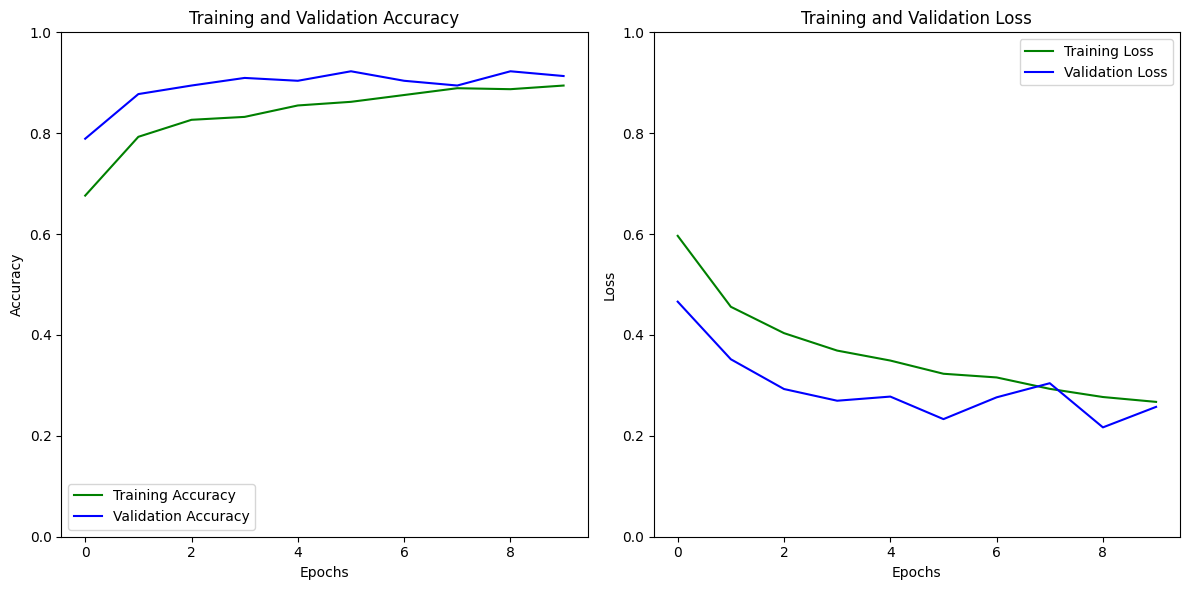

In [ ]:
# Print confusion matrix and classification report
print('Confusion Matrix')
print(confusion_matrix(test_labels2, binary_predictions2))
print('\nClassification Report')
target_names2 = ['No_DR', 'DR']
print(classification_report(test_labels2, binary_predictions2, target_names=target_names2))

# Print ROC AUC Score
auc_v2 = roc_auc_score(test_labels2, binary_predictions2)
print(f'ROC AUC: {auc_v2}')

# Plot training and validation accuracy and loss side by side
plt.figure(figsize=(12, 6))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'], 'g', label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim(0, 1)  # Set y-axis limits to [0, 1]

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], 'g', label='Training Loss')
plt.plot(history2.history['val_loss'], 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.ylim(0, 1)  # Set y-axis limits to [0, 1]

plt.tight_layout()
plt.show()

## **Base Model v3**

Changes in the architecture itself with the specs of compilation of v1

Dropout:

Dropout is a regularization technique commonly used in neural networks to prevent overfitting. Overfitting can occur when a model learns the training data noise and specific patterns that may not generalize well. Dropout helps to address this issue by randomly setting to zero a fraction of the neurons in a layer during training.

In [ ]:
import numpy as np
from numpy.random import seed
import pandas as pd
import random as rn
import os

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.compat.v1.keras import backend as K

tf.keras.backend.clear_session()

seed_num = 18
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(seed_num)
rn.seed(seed_num)
tf.random.set_seed(seed_num)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

In [ ]:
from tensorflow.keras.layers import Dropout

# Model
model3 = Sequential()
model3.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Conv2D(64, (3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Flatten())
model3.add(Dropout(0.5))
model3.add(Dense(units=128, activation='relu'))
model3.add(Dense(units=1, activation='sigmoid'))

In [ ]:
# Compiling the model
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Criating data generators for training, validation and testing
train_datagen3 = ImageDataGenerator(rescale=1./255,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode = 'nearest')

val_datagen3 = ImageDataGenerator(rescale=1./255)
test_datagen3 = ImageDataGenerator(rescale=1./255)

# Target_size will equal image resolution, to ensure minimal information loss
training_set3 = train_datagen3.flow_from_directory('/content/dataset/train',
                                                 target_size=(224, 224),
                                                 batch_size=32,
                                                 seed = seed,
                                                 class_mode='binary')

val_set3 = val_datagen3.flow_from_directory('/content/dataset/valid',
                                          target_size=(224, 224),
                                          batch_size=32,
                                          seed = seed,
                                          class_mode='binary')

test_set3 = test_datagen3.flow_from_directory('/content/dataset/test',
                                            target_size=(224, 224),
                                            batch_size=32,
                                            seed = seed,
                                            class_mode='binary',
                                            shuffle=False)  # Ensure order is maintained for later analysis

model3.summary()

Found 2076 images belonging to 2 classes.
Found 531 images belonging to 2 classes.
Found 231 images belonging to 2 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 186624)            0        

In [ ]:
# Training the model
history3 = model3.fit(training_set3, steps_per_epoch=len(training_set3), epochs=10, validation_data=val_set3, validation_steps=len(val_set3))

# Evaluating the model on validation set
eval_result_val3 = model3.evaluate(val_set3, steps=len(val_set3))
print(f"\nValidation Loss: {eval_result_val3[0]}, Validation Accuracy: {eval_result_val3[1]}")

# Evaluating the model on test set
eval_result_test3 = model3.evaluate(test_set3, steps=len(test_set3))
print(f"\nTest Loss: {eval_result_test3[0]}, Test Accuracy: {eval_result_test3[1]}")

# Predicting on test set
predictions3 = model3.predict(test_set3, steps=len(test_set3))

# Evaluating predictions
threshold = 0.5
binary_predictions3 = (predictions3 > threshold).astype(int)
test_labels3 = test_set3.classes

Epoch 1/10
65/65 [==============================] - 248s 4s/step - loss: 0.5993 - accuracy: 0.6782 - val_loss: 0.2926 - val_accuracy: 0.8832
Epoch 2/10
65/65 [==============================] - 245s 4s/step - loss: 0.3402 - accuracy: 0.8550 - val_loss: 0.2643 - val_accuracy: 0.9077
Epoch 3/10
65/65 [==============================] - 244s 4s/step - loss: 0.3060 - accuracy: 0.8791 - val_loss: 0.2738 - val_accuracy: 0.9153
Epoch 4/10
65/65 [==============================] - 242s 4s/step - loss: 0.2859 - accuracy: 0.8878 - val_loss: 0.2547 - val_accuracy: 0.9134
Epoch 5/10
65/65 [==============================] - 237s 4s/step - loss: 0.2672 - accuracy: 0.9022 - val_loss: 0.2412 - val_accuracy: 0.9171
Epoch 6/10
65/65 [==============================] - 234s 4s/step - loss: 0.2669 - accuracy: 0.8969 - val_loss: 0.2460 - val_accuracy: 0.9153
Epoch 7/10
65/65 [==============================] - 235s 4s/step - loss: 0.2404 - accuracy: 0.9109 - val_loss: 0.2673 - val_accuracy: 0.8927
Epoch 8/10
65

Confusion Matrix
[[ 98  15]
 [  5 113]]

Classification Report
              precision    recall  f1-score   support

       No_DR       0.95      0.87      0.91       113
          DR       0.88      0.96      0.92       118

    accuracy                           0.91       231
   macro avg       0.92      0.91      0.91       231
weighted avg       0.92      0.91      0.91       231

ROC AUC: 0.9124418779061048


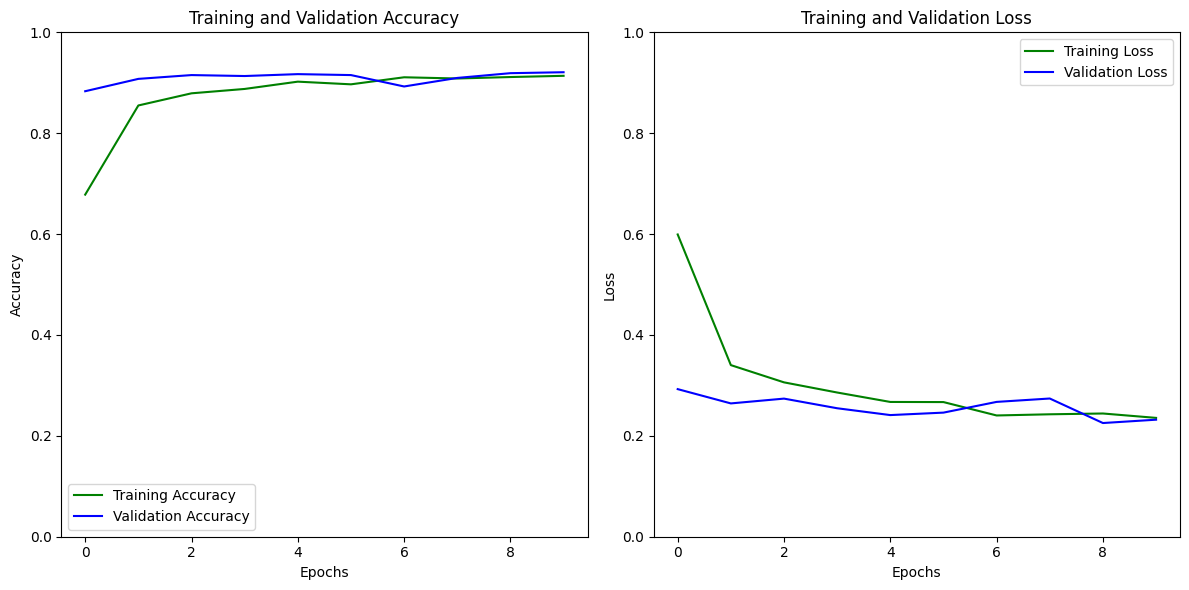

In [ ]:
# Print confusion matrix and classification report
print('Confusion Matrix')
print(confusion_matrix(test_labels3, binary_predictions3))
print('\nClassification Report')
target_names3 = ['No_DR', 'DR']
print(classification_report(test_labels3, binary_predictions3, target_names=target_names3))

# Print ROC AUC Score
auc_v3 = roc_auc_score(test_labels3, binary_predictions3)
print(f'ROC AUC: {auc_v3}')

# Plot training and validation accuracy and loss side by side
plt.figure(figsize=(12, 6))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history3.history['accuracy'], 'g', label='Training Accuracy')
plt.plot(history3.history['val_accuracy'], 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim(0, 1)  # Set y-axis limits to [0, 1]

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history3.history['loss'], 'g', label='Training Loss')
plt.plot(history3.history['val_loss'], 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.ylim(0, 1)  # Set y-axis limits to [0, 1]

plt.tight_layout()
plt.show()

## **Base Model v4**

Normalizing our dataset using V1 topology, while using local histogram equalization on the training set and tuning our data augmentation


In [ ]:
import numpy as np
from numpy.random import seed
import pandas as pd
import random as rn
import os

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.compat.v1.keras import backend as K

tf.keras.backend.clear_session()

seed_num = 18
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(seed_num)
rn.seed(seed_num)
tf.random.set_seed(seed_num)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage import exposure
import numpy as np

def local_histogram_equalization(img, window_size=(65, 65)):
    # Assuming img is in the range [0, 255]
    img = img.astype('float32') / 255.0

    # Apply local histogram equalization
    img = exposure.equalize_adapthist(img, kernel_size=window_size)

    return img

seed = 18

# Create a custom data generator with local histogram equalization
custom_datagen = ImageDataGenerator(
    preprocessing_function=local_histogram_equalization,
    shear_range=0.2,  # Reduce shear range
    channel_shift_range=0.2,  # Example of an additional parameter
    vertical_flip=True,
    horizontal_flip=True,
    rotation_range = 20,
    brightness_range = (0.1, 0.7),
    samplewise_std_normalization = True,
    samplewise_center = True
) #Accuracy

# Flow training images in batches from the directory
training_set4 = custom_datagen.flow_from_directory(
    '/content/dataset/train',
    target_size=(224, 224),
    batch_size=32,
    seed = seed,
    class_mode='binary'
)


# Create an ImageDataGenerator for validation and test data without scaling
val_datagen4 = ImageDataGenerator(rescale=1./255,samplewise_std_normalization = True, samplewise_center = True)
test_datagen4 = ImageDataGenerator(rescale=1./255,samplewise_std_normalization = True,samplewise_center = True)


# Flow validation images in batches from the directory
val_set4 = val_datagen4.flow_from_directory(
    '/content/dataset/valid',
    target_size=(224, 224),
    batch_size=32,
    seed = seed,
    class_mode='binary'
)

# Flow test images in batches from the directory
test_set4 = test_datagen4.flow_from_directory(
    '/content/dataset/test',
    target_size=(224, 224),
    batch_size=32,
    seed = seed,
    class_mode='binary',
    shuffle=False)

Found 2076 images belonging to 2 classes.
Found 531 images belonging to 2 classes.
Found 231 images belonging to 2 classes.


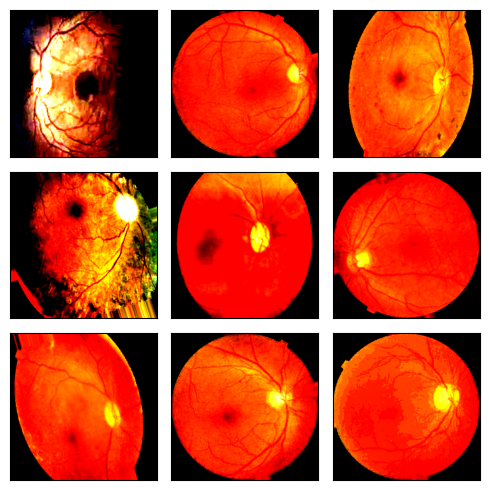

In [ ]:
# Grab a random batch of images from the training set
batch_images, _ = training_set4.next()

# Plot a few of the images
plt.figure(figsize=(5, 5))
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    plt.imshow(batch_images[i], vmin=0, vmax=1)
    plt.xticks([])
    plt.yticks([])

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
# Model
model4 = Sequential()
model4.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3), activation='relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Conv2D(64, (3, 3), activation='relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Flatten())
model4.add(Dense(units=128, activation='relu'))
model4.add(Dense(units=1, activation='sigmoid'))

# Compiling the model
model4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
model4.summary()

# Training the model
history4 = model4.fit(training_set4, steps_per_epoch=len(training_set4), epochs=5, validation_data=val_set4, validation_steps=len(val_set4))

# Evaluating the model on validation set
eval_result_val4 = model4.evaluate(val_set4, steps=len(val_set4))
print(f"\nValidation Loss: {eval_result_val4[0]}, Validation Accuracy: {eval_result_val4[1]}")

# Evaluating the model on test set
eval_result_test4 = model4.evaluate(test_set4, steps=len(test_set4))
print(f"\nTest Loss: {eval_result_test4[0]}, Test Accuracy: {eval_result_test4[1]}")

# Predicting on test set
predictions4 = model4.predict(test_set4, steps=len(test_set4))

# Evaluating predictions
threshold = 0.5
binary_predictions4 = (predictions4 > threshold).astype(int)
test_labels4 = test_set4.classes

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 186624)            0         
                                                                 
 dense (Dense)               (None, 128)               2

Confusion Matrix
[[107   6]
 [ 11 107]]

Classification Report
              precision    recall  f1-score   support

       No_DR       0.91      0.95      0.93       113
          DR       0.95      0.91      0.93       118

    accuracy                           0.93       231
   macro avg       0.93      0.93      0.93       231
weighted avg       0.93      0.93      0.93       231

ROC AUC: 0.9268411579421029


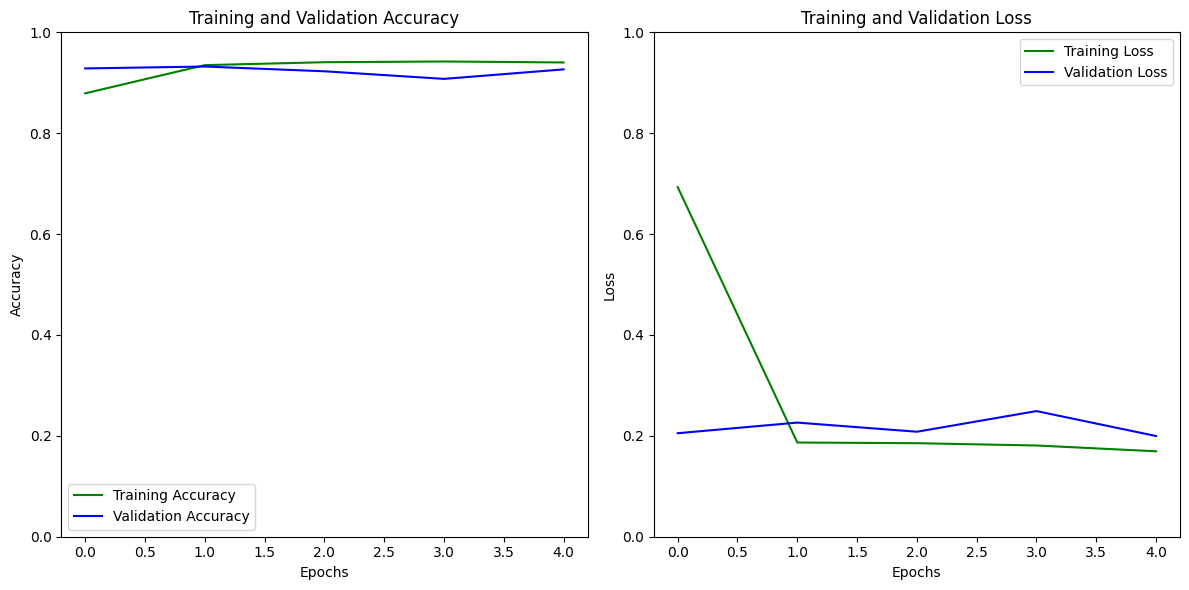

In [ ]:
# Print confusion matrix and classification report
print('Confusion Matrix')
print(confusion_matrix(test_labels4, binary_predictions4))
print('\nClassification Report')
target_names4 = ['No_DR', 'DR']
print(classification_report(test_labels4, binary_predictions4, target_names=target_names4))

# Print ROC AUC Score
auc_v4 = roc_auc_score(test_labels4, binary_predictions4)
print(f'ROC AUC: {auc_v4}')

# Plot training and validation accuracy and loss side by side
plt.figure(figsize=(12, 6))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history4.history['accuracy'], 'g', label='Training Accuracy')
plt.plot(history4.history['val_accuracy'], 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim(0, 1)  # Set y-axis limits to [0, 1]

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history4.history['loss'], 'g', label='Training Loss')
plt.plot(history4.history['val_loss'], 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.ylim(0, 1)  # Set y-axis limits to [0, 1]

plt.tight_layout()
plt.show()

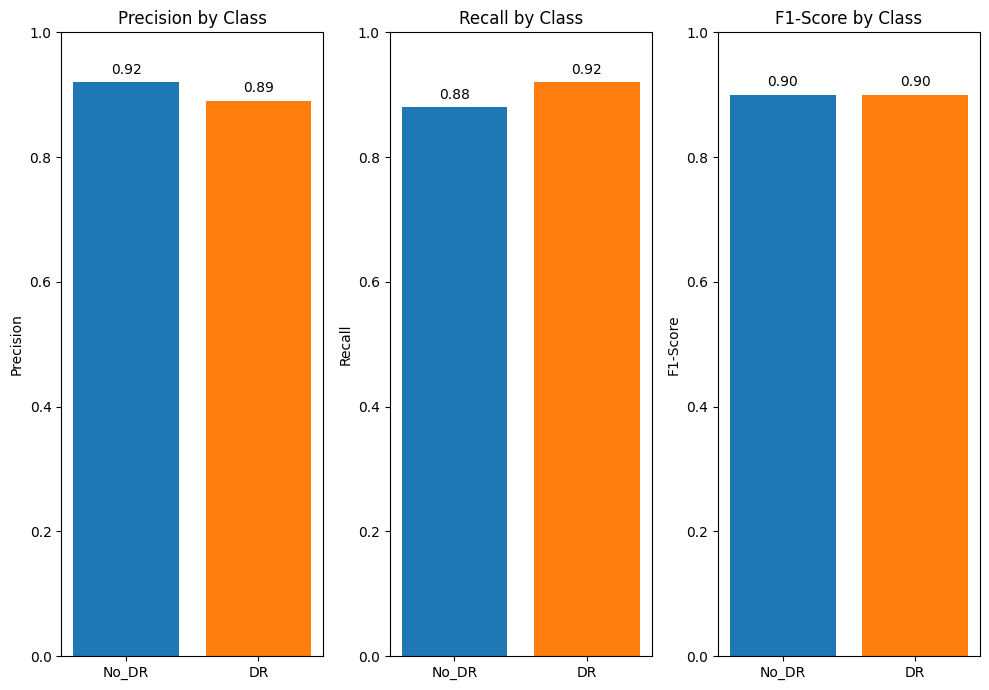

In [ ]:
metrics = {
    'Precision': [0.92, 0.89],
    'Recall': [0.88, 0.92],
    'F1-Score': [0.90, 0.90]
}
labels = ['No_DR', 'DR']

# Set up the figure size
plt.figure(figsize=(10, 7))

# Plot each metric in a separate subplot
for i, (metric, values) in enumerate(metrics.items(), 1):
    plt.subplot(1, 3, i)
    barlist = plt.bar(labels, values, color=['#1f77b4', '#ff7f0e'])
    plt.ylim(0, 1)  # Assuming the metric values are between 0 and 1
    plt.ylabel(metric)
    plt.title(f'{metric} by Class')
    for idx, rect in enumerate(barlist):
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., 1.01*height,
                 '%.2f' % values[idx],
                 ha='center', va='bottom')

plt.tight_layout()
plt.show()

## **Base Model v5**

Topology : v1
Data Augmentation: Fine Tuned and removed normalization from generator
Applied Local Histogram Equalizer


In [ ]:
tf.keras.backend.clear_session()

seed_num = 18
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(seed_num)
rn.seed(seed_num)
tf.random.set_seed(seed_num)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage import exposure
import numpy as np

def local_histogram_equalization(img, window_size=(65, 65)):
    # Assuming img is in the range [0, 255]
    img = img.astype('float32') / 255.0

    # Apply local histogram equalization
    img = exposure.equalize_adapthist(img, kernel_size=window_size)

    return img

seed =19

# Create a custom data generator with local histogram equalization and normalization for training
custom_datagen = ImageDataGenerator(
    preprocessing_function=local_histogram_equalization,
    shear_range=0.2,
    channel_shift_range=0.2,
    vertical_flip=True,
    horizontal_flip=True,
    rotation_range=20,
    brightness_range=(0.1, 0.9)
#     samplewise_center=True,
#     samplewise_std_normalization=True
)

# Flow training images in batches from the directory for training
training_set_5 = custom_datagen.flow_from_directory(
    '/content/dataset/train',
    target_size=(224, 224),
    batch_size=32,
    seed = seed,
    class_mode='binary'
)

# Create an ImageDataGenerator for validation and test data without scaling
val_datagen_5 = ImageDataGenerator(rescale=1./255) #,samplewise_center=True, samplewise_std_normalization=True )
test_datagen_5 = ImageDataGenerator(rescale=1./255) #, samplewise_center=True, samplewise_std_normalization=True)


# Flow validation images in batches from the directory
val_set_5 = val_datagen_5.flow_from_directory(
    '/content/dataset/valid',
    target_size=(224, 224),
    batch_size=32,
    seed = seed,
    class_mode='binary'
)

# Flow test images in batches from the directory
test_set_5 = test_datagen_5.flow_from_directory(
    '/content/dataset/test',
    target_size=(224, 224),
    batch_size=32,
    seed = seed,
    class_mode='binary',
    shuffle=False  # Ensure order is maintained for later analysis
)


Found 2076 images belonging to 2 classes.
Found 531 images belonging to 2 classes.
Found 231 images belonging to 2 classes.


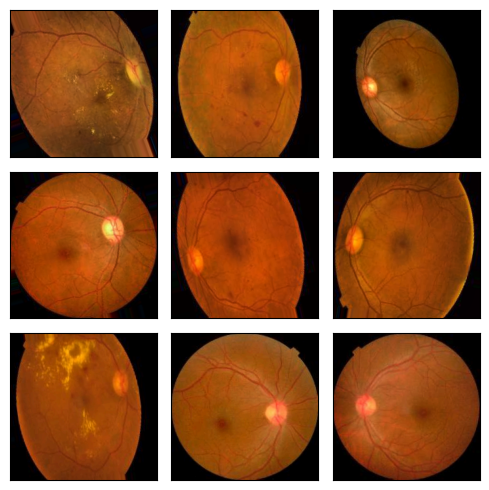

In [ ]:
# Grab a random batch of images from the training set
batch_images, _ = training_set_5.next()

# Plot a few of the images
plt.figure(figsize=(5, 5))
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    plt.imshow(batch_images[i], vmin=0, vmax=1)
    plt.xticks([])
    plt.yticks([])

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
# Model
model_5 = Sequential()
model_5.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3), activation='relu'))
model_5.add(MaxPooling2D(pool_size=(2, 2)))
model_5.add(Conv2D(64, (3, 3), activation='relu'))
model_5.add(MaxPooling2D(pool_size=(2, 2)))
model_5.add(Flatten())
model_5.add(Dense(units=128, activation='relu'))
model_5.add(Dense(units=1, activation='sigmoid'))

# Compiling the model
model_5.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_5.summary()

# Training the model
history_5 = model_5.fit(training_set_5, steps_per_epoch=len(training_set_5), epochs=5, validation_data=val_set_5, validation_steps=len(val_set_5))

# Evaluating the model on validation set
eval_resultv_5 = model_5.evaluate(val_set_5, steps=len(val_set_5))
print(f"\nValidation Loss: {eval_resultv_5[0]}, Validation Accuracy: {eval_resultv_5[1]}")

# Evaluating the model on test set
eval_resultt_5 = model_5.evaluate(test_set_5, steps=len(test_set_5))
print(f"\nTest Loss: {eval_resultt_5[0]}, Test Accuracy: {eval_resultt_5[1]}")

# Predicting on test set
predictions_5 = model_5.predict(test_set_5, steps=len(test_set_5))

# Evaluating predictions
threshold = 0.5
binary_predictions_5 = (predictions_5 > threshold).astype(int)
test_labels_5 = test_set_5.classes

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 186624)            0         
                                                                 
 dense (Dense)               (None, 128)               2

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 186624)            0         
                                                                 
 dense (Dense)               (None, 128)               2

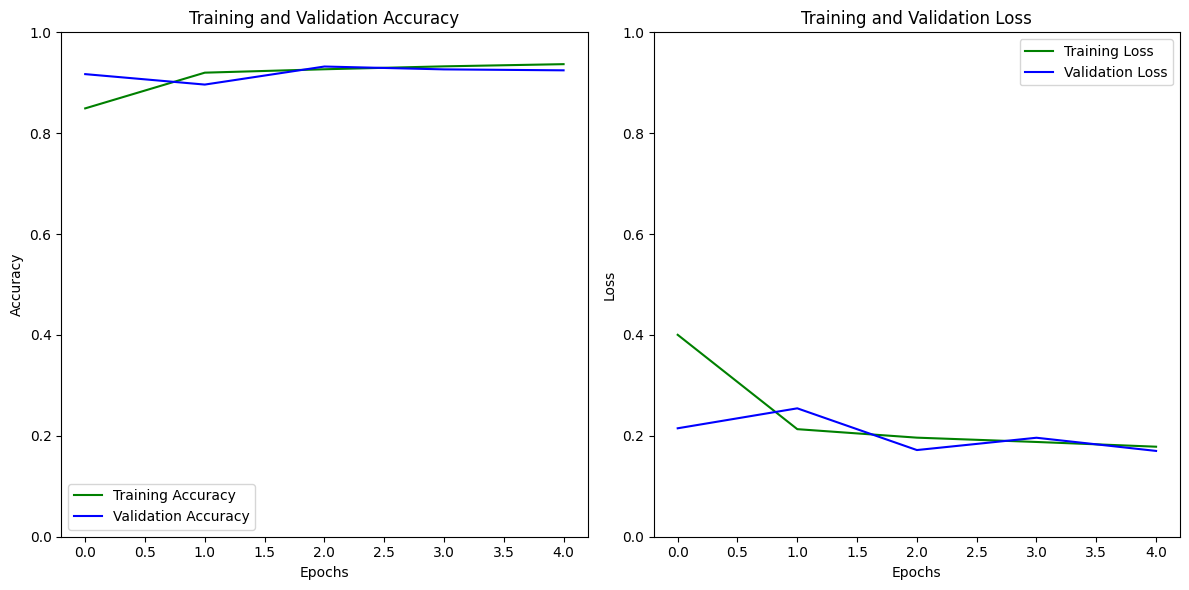

In [ ]:
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
# Calculate AUC
roc_auc_5 = roc_auc_score(test_labels_5, binary_predictions_5)
print(f'AUC: {roc_auc_5}')

# Print confusion matrix and classification report
print('Confusion Matrix')
print(confusion_matrix(test_labels_5, binary_predictions_5))
print('\nClassification Report')
target_names_5 = ['No_DR', 'DR']
print(classification_report(test_labels_5, binary_predictions_5, target_names=target_names_5))

# Plot training and validation accuracy and loss side by side
plt.figure(figsize=(12, 6))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history_5.history['accuracy'], 'g', label='Training Accuracy')
plt.plot(history_5.history['val_accuracy'], 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim(0, 1)  # Set y-axis limits to [0, 1]

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_5.history['loss'], 'g', label='Training Loss')
plt.plot(history_5.history['val_loss'], 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.ylim(0, 1)  # Set y-axis limits to [0, 1]

plt.tight_layout()
plt.show()

## **VGG-16 Model**

In [ ]:
import os
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score
from pathlib import Path
import numpy as np

In [ ]:
BATCH_SIZE = 32

train_generator = ImageDataGenerator(rotation_range=90,
                                     brightness_range=[0.3, 0.8],
                                     horizontal_flip=True,
                                     vertical_flip=True,
                                     preprocessing_function=preprocess_input) # VGG16 preprocessing



test_generator = ImageDataGenerator(preprocessing_function=preprocess_input) # VGG16 preprocessing

In [ ]:
traingen = train_generator.flow_from_directory('/content/dataset/train',
                                               target_size=(224, 224),
                                               class_mode='binary',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

validgen = train_generator.flow_from_directory('/content/dataset/valid',
                                               target_size=(224, 224),
                                               class_mode='binary',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

testgen = test_generator.flow_from_directory('/content/dataset/test',
                                             target_size=(224, 224),
                                             batch_size=1,
                                             shuffle=False,
                                             seed=42)

Found 2076 images belonging to 2 classes.
Found 531 images belonging to 2 classes.
Found 231 images belonging to 2 classes.


In [ ]:
def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    """
    Compiles a model integrated with VGG16 pretrained layers

    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """

    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = VGG16(include_top=False,
                     weights='imagenet',
                     input_shape=input_shape)

    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(4096, activation='relu')(top_model)
    top_model = Dense(1072, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(1, activation='sigmoid')(top_model)

    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])


    return model

In [ ]:
input_shape = (224, 224, 3)
optim_1 = Adam(learning_rate=0.001)
n_classes=2

n_steps = traingen.samples // BATCH_SIZE
n_val_steps = validgen.samples // BATCH_SIZE
n_epochs = 10

vgg_model = create_model(input_shape, n_classes, optim_1, fine_tune=0)

58889256/58889256 [==============================] - 2s 0us/step


In [ ]:
!pip install livelossplot

In [ ]:
from livelossplot.inputs.keras import PlotLossesCallback

plot_loss_1 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='tl_model_v1.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

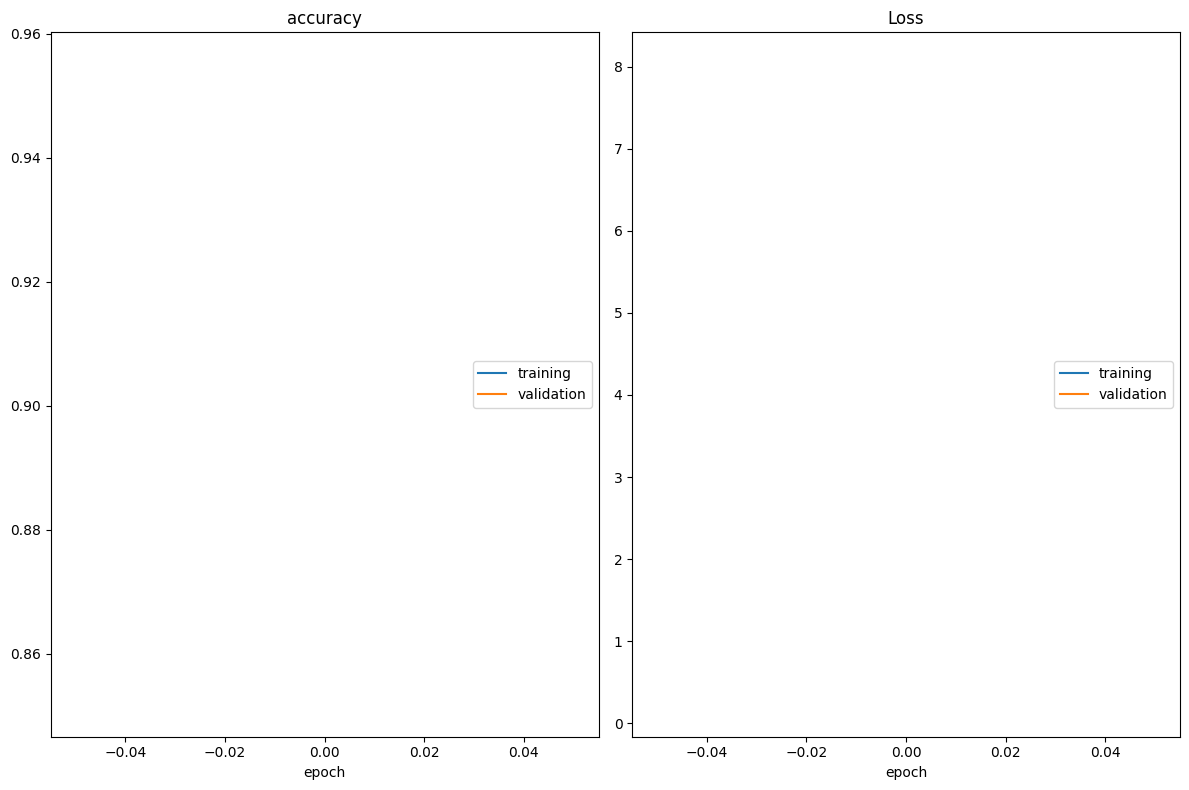

accuracy
	training         	 (min:    0.852, max:    0.852, cur:    0.852)
	validation       	 (min:    0.955, max:    0.955, cur:    0.955)
Loss
	training         	 (min:    8.028, max:    8.028, cur:    8.028)
	validation       	 (min:    0.226, max:    0.226, cur:    0.226)
64/64 [==============================] - 1893s 29s/step - loss: 8.0283 - accuracy: 0.8518 - val_loss: 0.2255 - val_accuracy: 0.9551
Epoch 2/10
64/64 [==============================] - ETA: 0s - loss: 0.2870 - accuracy: 0.9344 

In [ ]:
%%time

vgg_history = vgg_model.fit(traingen,
                            batch_size=BATCH_SIZE,
                            epochs=n_epochs,
                            validation_data=validgen,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[tl_checkpoint_1, early_stop, plot_loss_1],
                            verbose=1)

In [ ]:
# Predict on the test set
predictions_vgg16 = vgg_model.predict(testgen, steps=len(testgen))

# Evaluate predictions
threshold = 0.5
binary_predictions = (predictions_vgg16 > threshold).astype(int)
test_labels = testgen.classes

# Calculate AUC
roc_auc = roc_auc_score(test_labels, binary_predictions)
print(f'AUC: {roc_auc}')

# Print confusion matrix and classification report
print('Confusion Matrix')
print(confusion_matrix(test_labels, binary_predictions))
print('\nClassification Report')
target_names = ['No_DR', 'DR']
print(classification_report(test_labels, binary_predictions, target_names=target_names)

In [ ]:
# Generate predictions
vgg_model.load_weights('tl_model_v1.weights.best.hdf5') # initialize the best trained weights

true_classes = testgen.classes
class_indices = traingen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

vgg_preds = vgg_model.predict(testgen, steps=len(testgen))
vgg_pred_classes = np.argmax(vgg_preds, axis=1)

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Get the names of the classes
class_names = testgen.class_indices.keys()

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm,
        annot=True,
        square=True,
        xticklabels=class_names,
        yticklabels=class_names,
        fmt='d',
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_xlabel('True Label', fontsize=12)
    ax.set_ylabel('Predicted Label', fontsize=12)

fig, (ax1) = plt.subplots(1, 1, figsize=(20, 10))

plot_heatmap(true_classes, vgg_pred_classes, class_names, ax1, title="Transfer Learning (VGG16)")



fig.suptitle("Confusion Matrix Model Comparison", fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=0.85)
plt.show()

In [ ]:
print(vgg_pred_classes)

In [ ]:
# Reset our image data generators
traingen.reset()
validgen.reset()
testgen.reset()

# Use a smaller learning rate
optim_2 = Adam(lr=0.0001)

# Re-compile the model, this time leaving the last 2 layers unfrozen for Fine-Tuning
vgg_model_ft = create_model(input_shape, n_classes, optim_2, fine_tune=2)

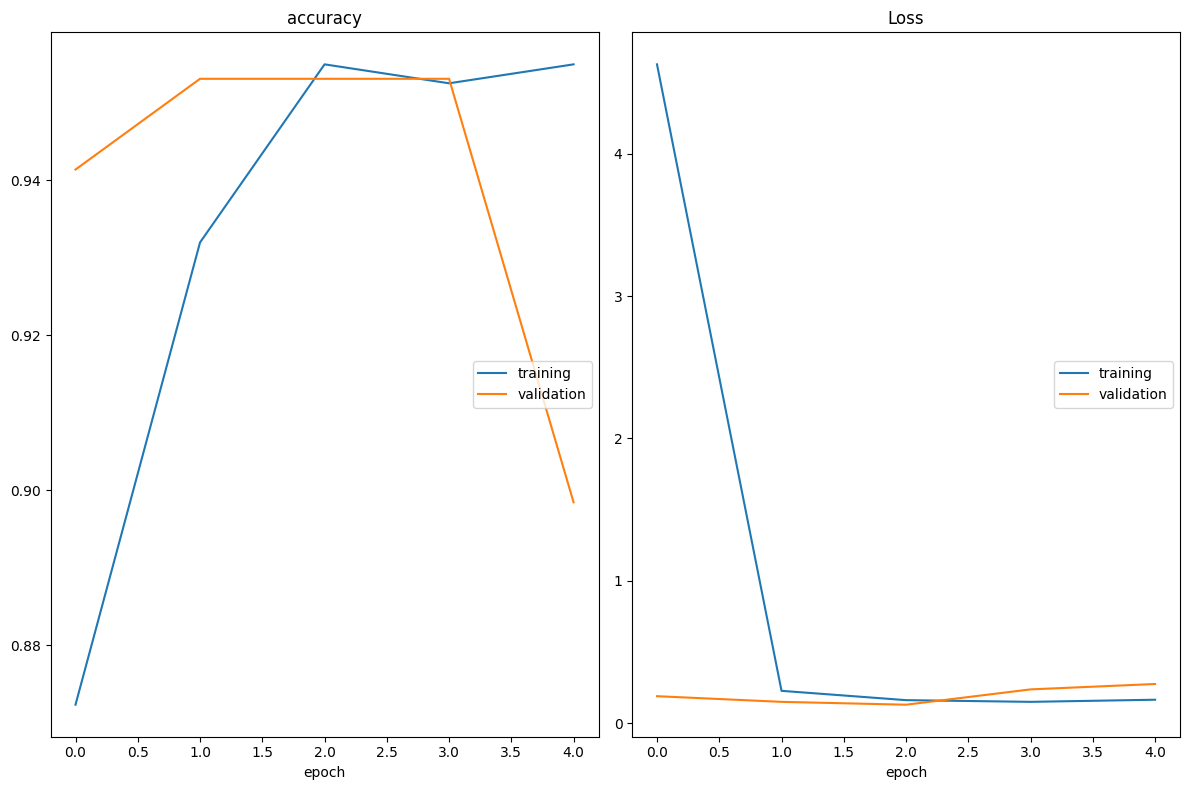

accuracy
	training         	 (min:    0.872, max:    0.955, cur:    0.955)
	validation       	 (min:    0.898, max:    0.953, cur:    0.898)
Loss
	training         	 (min:    0.150, max:    4.627, cur:    0.165)
	validation       	 (min:    0.130, max:    0.275, cur:    0.275)
64/64 [==============================] - 1772s 28s/step - loss: 0.1649 - accuracy: 0.9550 - val_loss: 0.2754 - val_accuracy: 0.8984
Epoch 6/10
62/64 [============================>.] - ETA: 45s - loss: 0.1565 - accuracy: 0.9540 

In [ ]:
%%time

plot_loss_2 = PlotLossesCallback()

# Retrain model with fine-tuning
vgg_ft_history = vgg_model_ft.fit(traingen,
                                  batch_size=BATCH_SIZE,
                                  epochs=n_epochs,
                                  validation_data=validgen,
                                  steps_per_epoch=n_steps,
                                  validation_steps=n_val_steps,
                                  callbacks=[tl_checkpoint_1, early_stop, plot_loss_2],
                                  verbose=1)

In [ ]:
# Generate predictions
vgg_model_ft.load_weights('tl_model_v1.weights.best.hdf5') # initialize the best trained weights

vgg_preds_ft = vgg_model_ft.predict(testgen)
vgg_pred_classes_ft = np.argmax(vgg_preds_ft, axis=1)

In [ ]:
predictions_vgg16_ft = vgg_model_ft.predict(testgen, steps=len(testgen))

# Avaliar as previsões
threshold = 0.5
binary_predictions_ft = (predictions_vgg16_ft > threshold).astype(int)
test_labels = testgen.classes

# Calculate AUC
roc_auc = roc_auc_score(test_labels, binary_predictions_ft)
print(f'AUC: {roc_auc}')

# Print confusion matrix and classification report
print('Confusion Matrix')
print(confusion_matrix(test_labels, binary_predictions_ft))
print('\nClassification Report')
target_names = ['No_DR', 'DR']
print(classification_report(test_labels, binary_predictions_ft, target_names=target_names))

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Get the names of the ten classes
class_names = testgen.class_indices.keys()

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm,
        annot=True,
        square=True,
        xticklabels=class_names,
        yticklabels=class_names,
        fmt='d',
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

fig, (ax1) = plt.subplots(1, 1, figsize=(20, 10))

plot_heatmap(true_classes, vgg_pred_classes, class_names, ax1, title="Transfer Learning (VGG16)")



fig.suptitle("Confusion Matrix Model Comparison", fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=0.85)
plt.show()

## **Hyperparemeter Tuning**

In [ ]:
!pip install keras_tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 3.0 MB/s eta 0:00:00


In [ ]:
tf.keras.backend.clear_session()

In [ ]:
import keras_tuner as kt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [ ]:
# Criar geradores de dados para treinamento, validação e teste
train_datagen5 = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
val_datagen5 = ImageDataGenerator(rescale=1./255)
test_datagen5 = ImageDataGenerator(rescale=1./255)

# O target_size vai ser igual à resolução da imagem, para perder o mínimo de informação
training_set5 = train_datagen5.flow_from_directory('/content/dataset/train',
                                                 target_size=(224, 224),
                                                 batch_size=32,
                                                 class_mode='binary')

val_set5 = val_datagen5.flow_from_directory('/content/dataset/valid',
                                          target_size=(224, 224),
                                          batch_size=32,
                                          class_mode='binary')

test_set5 = test_datagen5.flow_from_directory('/content/dataset/test',
                                            target_size=(224, 224),
                                            batch_size=32,
                                            class_mode='binary',
                                            shuffle=False)  # Ensure order is maintained for later analysis

Found 2076 images belonging to 2 classes.
Found 531 images belonging to 2 classes.
Found 231 images belonging to 2 classes.


In [ ]:
# Defining the model
def build_model(hp):
    model5 = Sequential()
    model5.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3), activation='relu'))
    model5.add(MaxPooling2D(pool_size=(2, 2)))
    model5.add(Conv2D(64, (3, 3), activation='relu'))
    model5.add(MaxPooling2D(pool_size=(2, 2)))
    model5.add(Flatten())
    model5.add(Dense(units=hp.Int('units', min_value=32, max_value=512, step=32), activation='relu'))
    model5.add(Dense(units=1, activation='sigmoid'))

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model5.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

    return model5

In [ ]:
# Initiating the Hyperband
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    directory='my_tuner_dir',  # Specify a directory for saving tuner logs and checkpoints
    project_name='Diabetic Retinopathy model5'
)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(training_set5, epochs=5, validation_data=val_set5, steps_per_epoch=len(training_set5), validation_steps=len(val_set5), callbacks=[stop_early])

# Get the best hyperparameters
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hp.get('units')} and the optimal learning rate for the optimizer
is {best_hp.get('learning_rate')}.
""")

Trial 16 Complete [00h 08m 49s]
val_accuracy: 0.9227871894836426

Best val_accuracy So Far: 0.9397363662719727
Total elapsed time: 02h 08m 29s

Search: Running Trial #17

Value             |Best Value So Far |Hyperparameter
288               |288               |units
0.001             |0.001             |learning_rate
10                |4                 |tuner/epochs
4                 |2                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
2                 |1                 |tuner/round
0013              |0006              |tuner/trial_id

Epoch 5/10
65/65 [==============================] - 264s 4s/step - loss: 0.2074 - accuracy: 0.9311 - val_loss: 0.1706 - val_accuracy: 0.9397
Epoch 6/10
65/65 [==============================] - 219s 3s/step - loss: 0.1833 - accuracy: 0.9350 - val_loss: 0.1920 - val_accuracy: 0.9284
Epoch 7/10
65/65 [==============================] - 220s 3s/step - loss: 0.1870 - accuracy: 0.9412 - val_loss: 0.2027 - val_accuracy:

In [ ]:
# Build the final model using the best hyperparameters
final_model = build_model(best_hp)

# Train the final model with the manually set batch size
final_model.fit(
     training_set5,
     epochs=15,
     validation_data=val_set5,
     steps_per_epoch=len(training_set5),
     validation_steps=len(val_set5),
     batch_size=32  # Manually set the batch size
 )

# # Evaluate the final model on the test set
test_results5 = final_model.evaluate(test_set5)
print("Test Results:", test_results)



Found 2076 images belonging to 2 classes.
Found 531 images belonging to 2 classes.
Found 231 images belonging to 2 classes.

Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
128               |128               |units

Epoch 1/5
15/65 [=====>........................] - ETA: 1:50 - loss: 1.5198 - accuracy: 0.5958

KeyboardInterrupt: ignored

#**More Hyperparamter Tuning**

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
import tempfile
import keras_tuner as kt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Create a temporary directory for the tuner to save its results
tuner_dir = tempfile.mkdtemp()
print('Tuner directory:', tuner_dir)

# Define the model with hyperparameter search space
def build_model(hp):
    model = Sequential()
    model.add(Conv2D(hp.Choice('units', values=[32, 64, 128]), (3, 3), input_shape=(224, 224, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(hp.Choice('units2', values=[64, 128, 256]), (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(units=hp.Choice('units3', values=[64, 128, 256, 512], default=128), activation='relu'))
    model.add(Dense(units=1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                   loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Criar geradores de dados para treinamento, validação e teste
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

training_set = train_datagen.flow_from_directory('/content/dataset/train',
                                                 target_size=(224, 224),
                                                 batch_size=32,
                                                 class_mode='binary')

val_set = val_datagen.flow_from_directory('/content/dataset/valid',
                                          target_size=(224, 224),
                                          batch_size=32,
                                          class_mode='binary')

test_set = test_datagen.flow_from_directory('/content/dataset/test',
                                            target_size=(224, 224),
                                            batch_size=32,
                                            class_mode='binary',
                                            shuffle=False)  # Ensure order is maintained for later analysis

# Initialize the Random Search tuner
tuner = kt.tuners.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    directory='tuner_dir',
    project_name='Diabetic_Retinopathy_model'
)

# Perform hyperparameter search using the training data
tuner.search(training_set, epochs=5, validation_data=val_set)

# Get the best hyperparameters
best_trial = tuner.oracle.get


In [ ]:
tf.keras.backend.clear_session()

In [ ]:
import tempfile
import keras_tuner as kt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping

# Create a temporary directory for the tuner to save its results
tuner_dir = tempfile.mkdtemp()
print('Tuner directory:', tuner_dir)

# Define the model building function
def build_model(hp):
    model = Sequential()
    model.add(Conv2D(hp.Int('units', min_value=32, max_value=512, step=32), (3, 3), input_shape=(224, 224, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(hp.Int('units2', min_value=64, max_value=1024, step=32), (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(units=hp.Choice('units3', values=[128, 256, 512], default=128), activation='relu'))
    model.add(Dense(units=1, activation='sigmoid'))

    # Set the learning rate using the hp.Choice hyperparameter
    optimizer = Adam(learning_rate=hp.Choice('learning_rate', values=[1e-4, 1e-3, 1e-2]))

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Load and preprocess the training and validation data
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)  # Create the test_datagen object

# O target_size vai ser igual à resolução da imagem, para perder o mínimo de informação
training_set = train_datagen.flow_from_directory('/content/dataset/train',
                                                 target_size=(224, 224),
                                                 batch_size=32,
                                                 class_mode='binary')

val_set = val_datagen.flow_from_directory('/content/dataset/valid',
                                          target_size=(224, 224),
                                          batch_size=32,
                                          class_mode='binary')

test_set = test_datagen.flow_from_directory('/content/dataset/test',
                                            target_size=(224, 224),
                                            batch_size=32,
                                            class_mode='binary',
                                            shuffle=False)  # Ensure order is maintained for later analysis

# Create the Random Search tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    directory=tuner_dir,
    project_name='Diabetic_Retinopathy_model'
)
# Enable the tuner progress bar
kt.tuners.randomsearch.display.enable_tuner_progress_bar()

# Search for the best hyperparameters
tuner.search(training_set, epochs=5, validation_data=val_set, steps_per_epoch=len(training_set), validation_steps=len(val_set), callbacks=[EarlyStopping(monitor='val_loss', patience=2)])

# Get the best model
best_model = tuner.get_best_models()[0]


# Evaluate the best model on the test data
test_loss, test_acc = best_model.evaluate(test_set)
print('Test Accuracy:', test_acc)

# Save the best model for future use
best_model.save('path/to/save/best_model.h5')
